# README

We are looking at the condition number of other models similar to the biexponential to look for similar numerical instability. We are looking for instability with the condition number calculation

# Libraries

In [1]:
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
from tqdm import trange
from datetime import date
import pickle
import pandas as pd
import sys
import os

# Initialization

In [2]:
TE_DATA = np.linspace(8, 512, 64) #ms units

noise_opt = True
SNR_value = 100
top_value = 1.5
######## Kurtosis Parameters - Second Order Cumulant Expansion

# b values described to range from 5.5 to 7.5 ms/um^2 --> Henrique paper 2019
# Jensen paper - Diffusion Coefficient = ranges from 0.5 to 1.10 um^2/ms


# Functions

In [3]:
def DiffKur(b, S_0, D, K):
    signal = S_0*np.exp(-b*D)*np.exp(-1/6*(b*D)**2*K)
    return signal

def stretchExp(TE, S_0, alp, tau):
    signal = S_0*np.exp(-(TE/tau)**alp)
    return signal

def G_biX(t, con_1, con_2, tau_1, tau_2): 
    signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return signal

In [4]:
def J_KD(b, S_0, D, K):
    parD = S_0*np.exp(-b*D)*np.exp(-1/6*(b*D)**2*K) * (1/3*b**2*D*K - b)
    parK = S_0*np.exp(-b*D)*np.exp(-1/6*(b*D)**2*K) * (1/6*b**2*D**2)

    jacobian = np.stack((parD, parK), axis = -1)
    return jacobian

def J_sExp(t, S_0, alp, tau):
    parA = S_0*np.exp(-(t/tau)**alp)*(-(t/tau)**alp)*(np.log(t/tau))
    parT = S_0*np.exp(-(t/tau)**alp)*(alp)*((t**alp/tau**(alp+1)))

    jacobian = np.stack((parA, parT), axis = -1)
    return jacobian

def J_biX(TE, d1, d2, T21, T22):
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

def J_moX(TE, d, T2):
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd = np.exp(-TE/T2)
    dT2 = (d*TE/T2**2)*np.exp(-TE/T2)
    
    jacobian = np.stack((dd, dT2), axis = -1)
    return jacobian

In [5]:
D_range = np.arange(0, 5.001, 0.1)
K_range = np.arange(0, 3.001, 0.1)
b_range = np.arange(0, 3.001, 0.1)

KD_CN_array = np.zeros([len(K_range), len(D_range)])

for iD in range(len(D_range)):
    for iK in range((len(K_range))):
        B_mat = J_KD(b_range, 1, D_range[iD], K_range[iK])
        KD_CN_array[iK, iD] = np.linalg.cond(B_mat)

C:\Users\griff\AppData\Local\Temp\ipykernel_19616\3371742921.py:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12
c:\co\NIA\Regularization\.venv\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:180: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


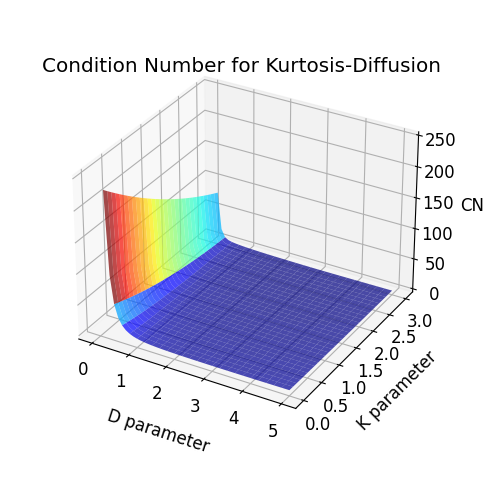

In [6]:
mD, mK = np.meshgrid(D_range, K_range)

fig = plt.figure(figsize = (7,5), tight_layout=True)
plt.rc('font', size = 12)
ax = plt.axes(projection='3d')

ax.plot_surface(mD, mK, KD_CN_array, alpha = 0.7, cmap = 'jet')
# ax.view_init(25,160)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 12
ax.zaxis.labelpad = 9

ax.set_xlabel('D parameter')
ax.set_ylabel('K parameter')
ax.set_zlabel('CN')
ax.set_title('Condition Number for Kurtosis-Diffusion', y=1.0, pad=-18)
ax.set_zlim([0,250])
ax.dist = 12

plt.show()

In [7]:
Alp_range = np.arange(0, 1, 0.01)
Tau_range = np.arange(30, 110, 2)
TE_range = np.linspace(8, 8*64, 64)

sExp_CN_array = np.zeros([len(Tau_range), len(Alp_range)])

for iA in range(len(Alp_range)):
    for iT in range((len(Tau_range))):
        B_mat = J_sExp(TE_range, 1, Alp_range[iA], Tau_range[iT])
        sExp_CN_array[iT, iA] = np.linalg.cond(B_mat)

C:\Users\griff\AppData\Local\Temp\ipykernel_19616\3066135972.py:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


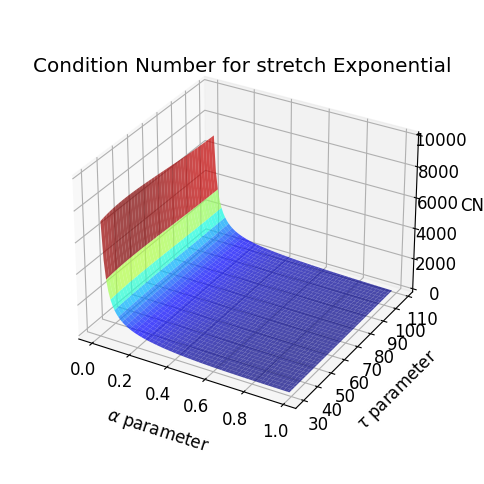

In [8]:
mA, mT = np.meshgrid(Alp_range, Tau_range)

fig = plt.figure(figsize = (7,5), tight_layout=True)
plt.rc('font', size = 12)
ax = plt.axes(projection='3d')

ax.plot_surface(mA, mT, sExp_CN_array, alpha = 0.7, cmap = 'jet')
# ax.view_init(25,160)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 12
ax.zaxis.labelpad = 9

ax.set_xlabel(r'$\alpha$ parameter')
ax.set_ylabel(r'$\tau$ parameter')
ax.set_zlabel('CN')
ax.set_title('Condition Number for stretch Exponential', y=1.0, pad=-18)
ax.set_zlim([0,10000])
ax.dist = 12

plt.show()

In [9]:
T2_range = np.arange(20, 100, 0.5)
TE_range = np.linspace(8, 8*64, 64)

biX_CN_array = np.zeros([len(T2_range), len(T2_range)])

for iT1 in range(len(T2_range)):
    for iT2 in range((len(T2_range))):
        B_mat = J_biX(TE_range, 0.3, 0.7, T2_range[iT1], T2_range[iT2])
        biX_CN_array[iT1, iT2] = np.linalg.cond(B_mat)

C:\Users\griff\AppData\Local\Temp\ipykernel_19616\3720488374.py:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


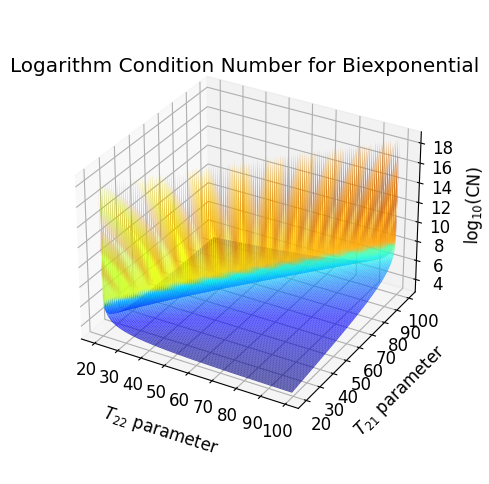

In [10]:
mT1, mT2 = np.meshgrid(T2_range, T2_range)

fig = plt.figure(figsize = (7,5), tight_layout=True)
plt.rc('font', size = 12)
ax = plt.axes(projection='3d')

ax.plot_surface(mT1, mT2, np.log10(biX_CN_array), alpha = 0.7, cmap = 'jet', antialiased = True, rstride = 1, cstride = 1)
# ax.view_init(25,160)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 12
ax.zaxis.labelpad = 9

ax.set_xlabel(r'$T_{22}$ parameter')
ax.set_ylabel(r'$T_{21}$ parameter')
ax.set_zlabel(r'log$_{10}$(CN)')
ax.set_title('Logarithm Condition Number for Biexponential', y=1.0, pad=-18)
# ax.set_zlim([0,10000])
ax.dist = 12

plt.show()

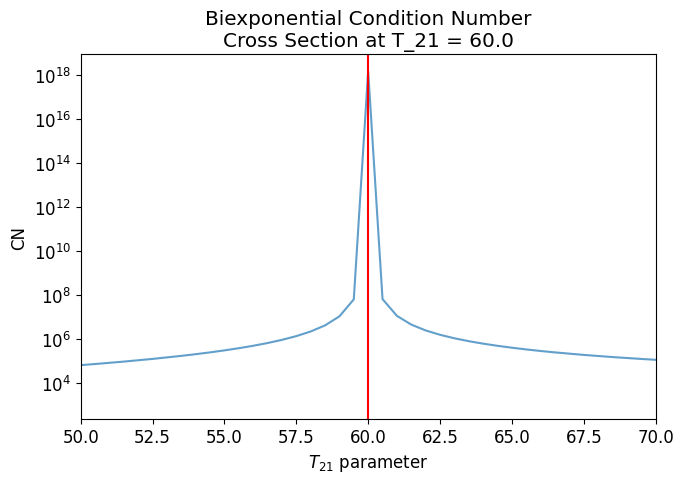

In [11]:
fig = plt.figure(figsize = (7,5), tight_layout=True)
plt.rc('font', size = 12)
ax = plt.axes()

ax.semilogy(T2_range, biX_CN_array[:,int(len(T2_range)/2)], alpha = 0.7)
# ax.view_init(25,160)


ax.set_xlabel(r'$T_{21}$ parameter')
ax.set_ylabel('CN')
# ax.set_zlabel('CN')
ax.set_title(f'Biexponential Condition Number\nCross Section at T_21 = {T2_range[int(len(T2_range)/2)]}')
ax.axvline(x = T2_range[int(len(T2_range)/2)], color = 'r')
ax.set_xlim([50,70])
# ax.set_zlim([0,10000])
# ax.dist = 12

plt.show()

In [12]:
T2_range = np.arange(10, 100, 0.5)
TE_range = np.linspace(8, 8*64, 64)

fixed_T21 = 60
fixed_c1 = 0.3
fixed_c2 = 0.7

biX_CN = np.zeros([len(T2_range)])
moX_CN = np.zeros([len(T2_range)])

for iT in range(len(T2_range)):

    B_mat = J_biX(TE_range, fixed_c1, fixed_c2, fixed_T21, T2_range[iT])
    biX_CN[iT] = np.linalg.cond(B_mat)

    B_mat = J_moX(TE_range, fixed_c2, T2_range[iT])
    moX_CN[iT] = np.linalg.cond(B_mat)



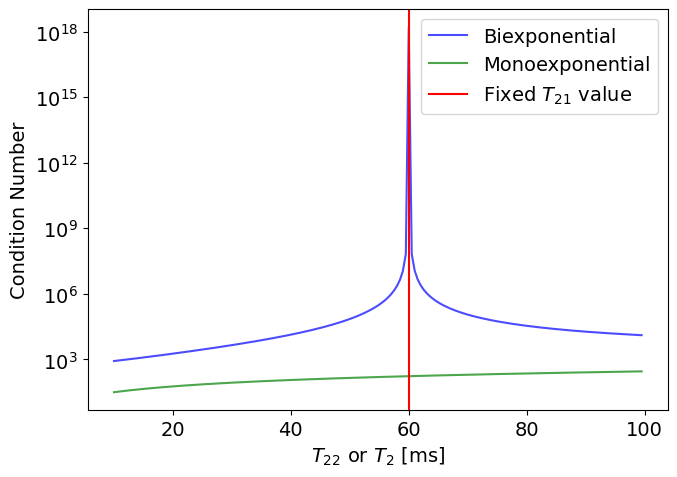

In [28]:
fig = plt.figure(figsize = (7,5), tight_layout=True)
plt.rc('font', size = 14)
ax = plt.axes()

ax.semilogy(T2_range, biX_CN, alpha = 0.7, label = 'Biexponential', color = 'b')
ax.semilogy(T2_range, moX_CN, alpha = 0.7, label = 'Monoexponential', color = 'g')
# ax.view_init(25,160)

param_string = r'$c_1$, $c_2$, $T_{21}$'
ax.set_xlabel(r'$T_{22}$ or $T_{2}$ [ms]')
ax.set_ylabel('Condition Number')
# ax.set_zlabel('CN')
# ax.set_title(f'Condition Number\nBiexponential [{param_string}] = [{fixed_c1},{fixed_c2},{fixed_T21}]\nMonoexponential [c] = [{fixed_c2}]')
ax.axvline(x = fixed_T21, color = 'r', label = r'Fixed $T_{21}$ value')
# ax.set_xlim([50,70])
# ax.set_zlim([0,10000])
# ax.dist = 12
ax.legend()

plt.show()

# RSS Surfaces Fucntions

In [14]:
#All curves get noise according to this equation
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = 1/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

def calculate_RSS(input, func, popt, data):
    est_curve = func(input, *popt)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

# Kurtosis-Diffusion Model rootRSS Surface

In [15]:
K_center = 0.9
D_center = 0.8

K_range = np.arange(K_center-0.4, K_center+.4+.001, 0.01)
D_range = np.arange(D_center-0.4, D_center+.4+.001, 0.01)

true_signal_KD = DiffKur(b_range, 1, D_center, K_center)

if noise_opt:
    true_signal_KD = add_noise(true_signal_KD, SNR_value)

surface_array_KD = np.zeros([len(K_range), len(D_range)])

for iK in range(len(K_range)):
    for iD in range(len(D_range)):
        temp_param = [1, D_range[iD], K_range[iK]]
        temp_RSS = calculate_RSS(b_range, DiffKur, temp_param, true_signal_KD)
        surface_array_KD[iK, iD] = temp_RSS

trueP_RSS_KD = calculate_RSS(b_range, DiffKur, [1,D_center,K_center], true_signal_KD)

Text(0.5, 1.0, 'True Signal for Kurtosis-Diffusion Model\nS_0, D, K = 1, 0.8, 0.9')

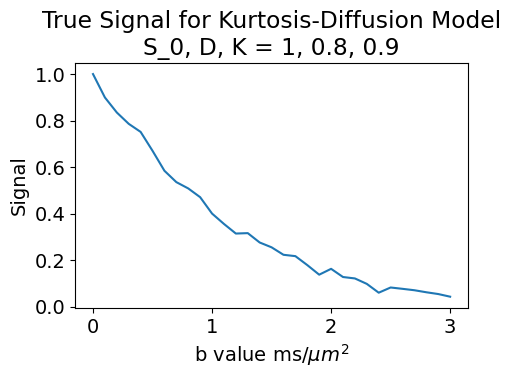

In [16]:
fig = plt.figure(figsize=(5,4), tight_layout=True)
plt.plot(b_range, true_signal_KD)
plt.xlabel(r'b value ms/$\mu m^2$')
plt.ylabel('Signal')
plt.title(f'True Signal for Kurtosis-Diffusion Model\nS_0, D, K = {1}, {D_center}, {K_center}')

C:\Users\griff\AppData\Local\Temp\ipykernel_19616\3110233304.py:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 12


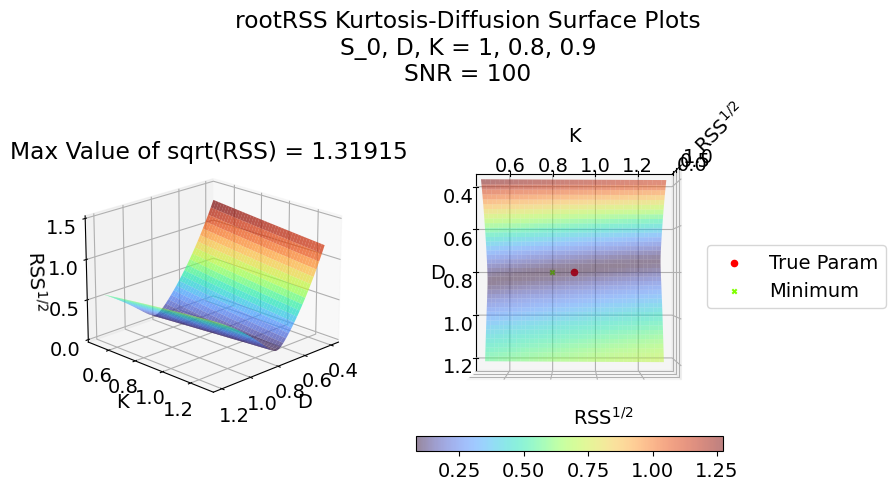

In [17]:
mD, mK = np.meshgrid(D_range, K_range)

fig = plt.figure(figsize=(9,5), tight_layout=True)

ax = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(ax[0], projection = '3d')

rootRSS = surface_array_KD**(1/2)

ax1.plot_surface(mD, mK, rootRSS, alpha = 0.7, cmap = 'turbo')
ax1.set_xlabel('D')
ax1.set_ylabel('K')
ax1.set_zlabel(r'RSS$^{1/2}$')
ax1.set_zlim([0,top_value])
ax1.set_title(f'Max Value of sqrt(RSS) = {np.max(rootRSS):.5f}', y=1.0, pad=-10)
ax1.view_init(20,45)
ax1.dist = 12

ax1 = fig.add_subplot(ax[1], projection = '3d')

flat = ax1.plot_surface(mD, mK, rootRSS, alpha = 0.5, cmap = 'turbo')
ax1.set_xlabel('D')
ax1.set_ylabel('K')
ax1.set_zlabel(r'RSS$^{1/2}$')
ax1.scatter(D_center, K_center, trueP_RSS_KD, color = (1,0,0), marker = 'o', s = 20, label = 'True Param')
min_indices = np.unravel_index(rootRSS.argmin(), rootRSS.shape)
ax1.scatter(D_range[min_indices[1]], K_range[min_indices[0]], np.min(rootRSS), color = (0.5,1,0), marker = 'x', s = 10, label = 'Minimum')
ax1.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
# ax1.set_title('RSS Surface')
ax1.view_init(90,0)
fig.colorbar(flat, ax=ax1, fraction=0.046, pad = 0.0001, location = 'bottom')
fig.text(0.65, 0.15, r'RSS$^{1/2}$', ha='center')

if noise_opt:
    noise_info = f"SNR = {SNR_value}"
else:
    noise_info = "noiseless"

fig.suptitle(f"rootRSS Kurtosis-Diffusion Surface Plots\nS_0, D, K = {1}, {D_center}, {K_center}\n" + noise_info)

plt.show()

# Stretch Exponential rootRSS Surface

In [18]:
A_center = 0.8
T_center = 70

A_range = np.arange(A_center-0.2, A_center+.2+.001, 0.01)
T_range = np.arange(T_center-30, T_center+30+.001, 1)

true_signal_sX = stretchExp(TE_DATA, 1, A_center, T_center)

if noise_opt:
    true_signal_sX = add_noise(true_signal_sX, SNR_value)

surface_array_sX = np.zeros([len(T_range), len(A_range)])

for iA in range(len(A_range)):
    for iT in range(len(T_range)):
        temp_param = [1, A_range[iA], T_range[iT]]
        temp_RSS = calculate_RSS(TE_range, stretchExp, temp_param, true_signal_sX)
        surface_array_sX[iT, iA] = temp_RSS

trueP_RSS_sX = calculate_RSS(TE_range, stretchExp, [1, A_center, T_center], true_signal_sX)

Text(0.5, 1.0, 'True Signal for Stretch Exponential Model\nS_0, $\\alpha$, $\\tau$ = 1, 0.8, 70')

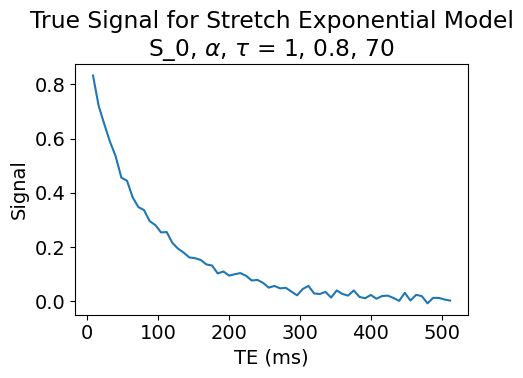

In [19]:
fig = plt.figure(figsize=(5,4), tight_layout=True)
plt.plot(TE_range, true_signal_sX)
plt.xlabel(r'TE (ms)')
plt.ylabel('Signal')
alp_label = r'$\alpha$'
tau_label = r'$\tau$'
plt.title(f'True Signal for Stretch Exponential Model\nS_0, {alp_label}, {tau_label} = {1}, {A_center}, {T_center}')

C:\Users\griff\AppData\Local\Temp\ipykernel_19616\1162884734.py:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 12


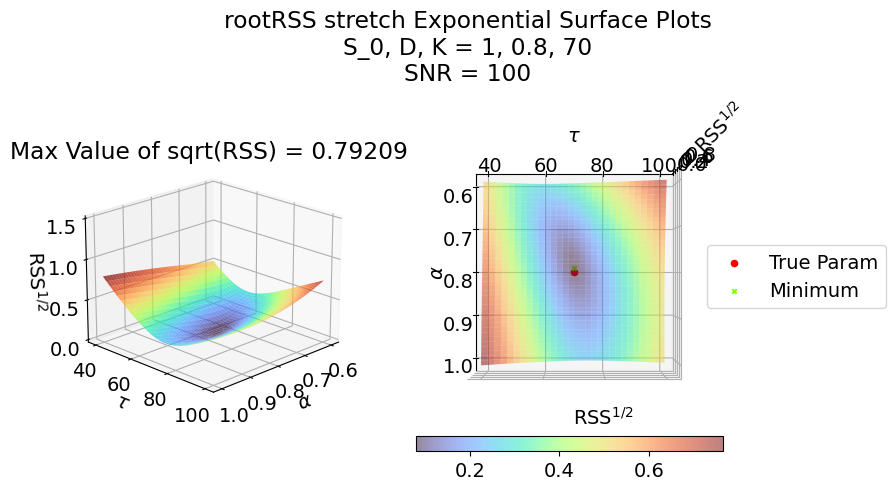

In [20]:
mA, mT = np.meshgrid(A_range, T_range)

fig = plt.figure(figsize=(9,5), tight_layout=True)

ax = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(ax[0], projection = '3d')

rootRSS = surface_array_sX**(1/2)

ax1.plot_surface(mA, mT, rootRSS, alpha = 0.7, cmap = 'turbo')
ax1.set_xlabel(alp_label)
ax1.set_ylabel(tau_label)
ax1.set_zlabel(r'RSS$^{1/2}$')
ax1.set_zlim([0,top_value])
ax1.set_title(f'Max Value of sqrt(RSS) = {np.max(rootRSS):.5f}', y=1.0, pad=-10)
ax1.view_init(20,45)
ax1.dist = 12

ax1 = fig.add_subplot(ax[1], projection = '3d')

flat = ax1.plot_surface(mA, mT, rootRSS, alpha = 0.5, cmap = 'turbo')
ax1.set_xlabel(alp_label)
ax1.set_ylabel(tau_label)
ax1.set_zlabel(r'RSS$^{1/2}$')
ax1.scatter(A_center, T_center, trueP_RSS_KD, color = (1,0,0), marker = 'o', s = 20, label = 'True Param')
min_indices = np.unravel_index(rootRSS.argmin(), rootRSS.shape)
ax1.scatter(A_range[min_indices[1]], T_range[min_indices[0]], np.min(rootRSS), color = (0.5,1,0), marker = 'x', s = 10, label = 'Minimum')
ax1.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
# ax1.set_title('RSS Surface')
ax1.view_init(90,0)
fig.colorbar(flat, ax=ax1, fraction=0.046, pad = 0.0001, location = 'bottom')
fig.text(0.65, 0.15, r'RSS$^{1/2}$', ha='center')

if noise_opt:
    noise_info = f"SNR = {SNR_value}"
else:
    noise_info = "noiseless"

fig.suptitle(f"rootRSS stretch Exponential Surface Plots\nS_0, D, K = {1}, {A_center}, {T_center}\n" + noise_info)

plt.show()

# Biexponential Model rootRSS Surface

In [21]:
T21_center = 40
T22_center = 50

T21_range = np.arange(T21_center-30, T21_center+30+.001, 1)
T22_range = np.arange(T22_center-30, T22_center+30+.001, 1)

true_signal_biX = G_biX(TE_range, 0.3, 0.7, T21_center, T22_center)

if noise_opt:
    true_signal_biX = add_noise(true_signal_biX, SNR_value)

surface_array_biX = np.zeros([len(T22_range), len(T21_range)])

for iT21 in range(len(T21_range)):
    for iT22 in range(len(T22_range)):
        temp_param = [0.3, 0.7, T21_range[iT21], T22_range[iT22]]
        temp_RSS = calculate_RSS(TE_range, G_biX, temp_param, true_signal_biX)
        surface_array_biX[iT22, iT21] = temp_RSS

trueP_RSS_biX = calculate_RSS(TE_range, G_biX, [0.3, 0.7, T21_center, T22_center], true_signal_biX)

Text(0.5, 1.0, 'True Signal for Biexponential Model\nc1, c2, $T_{21}$, $T_{22}$ = 0.3, 0.7, 40, 50')

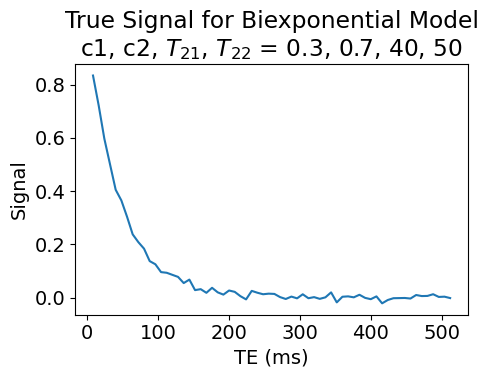

In [22]:
fig = plt.figure(figsize=(5,4), tight_layout=True)
plt.plot(TE_range, true_signal_biX)
plt.xlabel(r'TE (ms)')
plt.ylabel('Signal')
T21_label = r'$T_{21}$'
T22_label = r'$T_{22}$'
plt.title(f'True Signal for Biexponential Model\nc1, c2, {T21_label}, {T22_label} = 0.3, 0.7, {T21_center}, {T22_center}')

C:\Users\griff\AppData\Local\Temp\ipykernel_19616\813786630.py:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 12


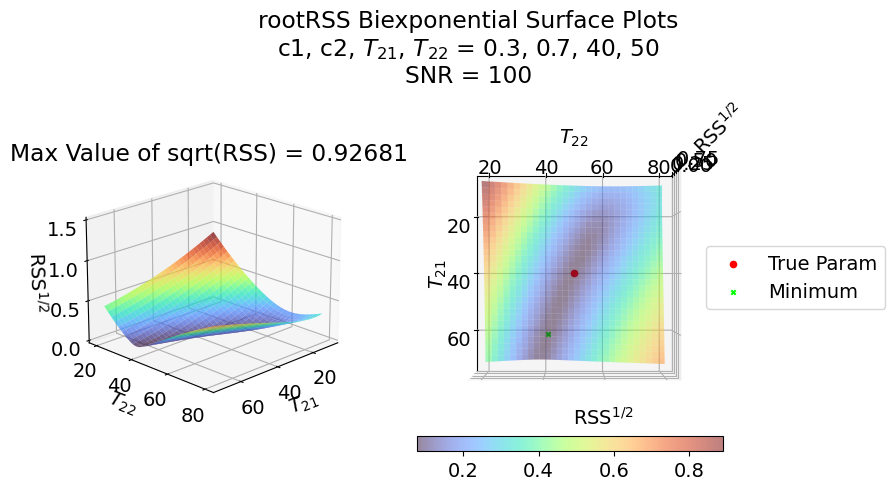

In [23]:
mT21, mT22 = np.meshgrid(T21_range, T22_range)

fig = plt.figure(figsize=(9,5), tight_layout=True)

ax = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(ax[0], projection = '3d')

rootRSS = surface_array_biX**(1/2)

ax1.plot_surface(mT21, mT22, rootRSS, alpha = 0.7, cmap = 'turbo')
ax1.set_xlabel(T21_label)
ax1.set_ylabel(T22_label)
ax1.set_zlabel(r'RSS$^{1/2}$')
ax1.set_zlim([0,top_value])
ax1.set_title(f'Max Value of sqrt(RSS) = {np.max(rootRSS):.5f}', y=1.0, pad=-10)
ax1.view_init(20,45)
ax1.dist = 12

ax1 = fig.add_subplot(ax[1], projection = '3d')

flat = ax1.plot_surface(mT21, mT22, rootRSS, alpha = 0.5, cmap = 'turbo')
ax1.set_xlabel(T21_label)
ax1.set_ylabel(T22_label)
ax1.set_zlabel(r'RSS$^{1/2}$')
ax1.scatter(T21_center, T22_center, trueP_RSS_biX, color = (1,0,0), marker = 'o', s = 20, label = 'True Param')
min_indices = np.unravel_index(rootRSS.argmin(), rootRSS.shape)
ax1.scatter(T21_range[min_indices[1]], T22_range[min_indices[0]], np.min(rootRSS), color = (0,1,0), marker = 'x', s = 10, label = 'Minimum')
ax1.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
# ax1.set_title('RSS Surface')
ax1.view_init(90,0)
fig.colorbar(flat, ax=ax1, fraction=0.046, pad = 0.0001, location = 'bottom')
fig.text(0.65, 0.15, r'RSS$^{1/2}$', ha='center')

if noise_opt:
    noise_info = f"SNR = {SNR_value}"
else:
    noise_info = "noiseless"

fig.suptitle(f"rootRSS Biexponential Surface Plots\nc1, c2, {T21_label}, {T22_label} = 0.3, 0.7, {T21_center}, {T22_center}\n" + noise_info)

plt.show()

# All Curves - Contour

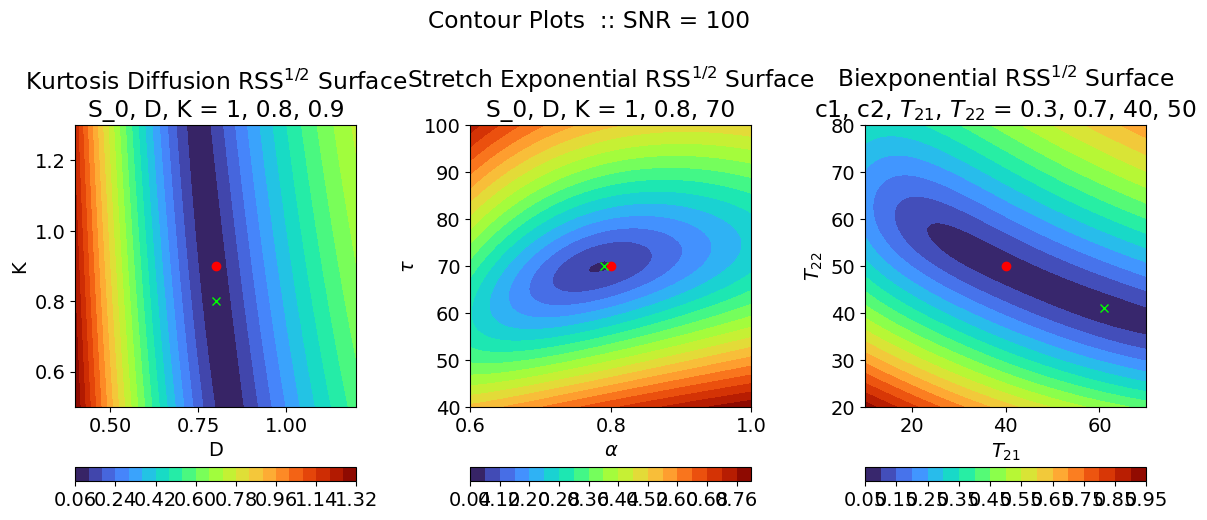

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(12,5.5), tight_layout=True)
fig.suptitle(f"Contour Plots  :: " + noise_info)

RRSS = r'RSS$^{1/2}$'

rootRSS = surface_array_KD**(1/2)
cp = ax[0].contourf(mD, mK, rootRSS, 20, cmap = 'turbo')
ax[0].plot(D_center, K_center, color = (1,0,0), marker = 'o', label = 'True Param')
min_indices = np.unravel_index(rootRSS.argmin(), rootRSS.shape)
ax[0].plot(D_range[min_indices[1]], K_range[min_indices[0]], color = (0,1,0), marker = 'x', label = 'Minimum')
ax[0].set_xlabel('D')
ax[0].set_ylabel('K')
ax[0].set_title(f'Kurtosis Diffusion {RRSS} Surface' + f"\nS_0, D, K = {1}, {D_center}, {K_center}")
fig.colorbar(cp, ax = ax[0], location = 'bottom')


rootRSS = surface_array_sX**(1/2)
cp = ax[1].contourf(mA, mT, rootRSS, 20, cmap = 'turbo')
ax[1].plot(A_center, T_center, color = (1,0,0), marker = 'o', label = 'True Param')
min_indices = np.unravel_index(rootRSS.argmin(), rootRSS.shape)
ax[1].plot(A_range[min_indices[1]], T_range[min_indices[0]], color = (0,1,0), marker = 'x', label = 'Minimum')
ax[1].set_xlabel(alp_label)
ax[1].set_ylabel(tau_label)
ax[1].set_title(f'Stretch Exponential {RRSS} Surface' + f"\nS_0, D, K = {1}, {A_center}, {T_center}")
fig.colorbar(cp, ax = ax[1], location = 'bottom')


rootRSS = surface_array_biX**(1/2)
cp = ax[2].contourf(mT21, mT22, rootRSS, 20, cmap = 'turbo')
ax[2].plot(T21_center, T22_center, color = (1,0,0), marker = 'o', label = 'True Param')
min_indices = np.unravel_index(rootRSS.argmin(), rootRSS.shape)
ax[2].plot(T21_range[min_indices[1]], T22_range[min_indices[0]], color = (0,1,0), marker = 'x', label = 'Minimum')
ax[2].set_xlabel(T21_label)
ax[2].set_ylabel(T22_label)
ax[2].set_title(f'Biexponential {RRSS} Surface' + f"\nc1, c2, {T21_label}, {T22_label} = 0.3, 0.7, {T21_center}, {T22_center}")
fig.colorbar(cp, ax = ax[2], location = 'bottom')